In [19]:
# Setup - import library and load data from local file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

In [20]:
# We don't want fuzzy figures. Set to higher quality sharp images please
plt.rcParams['figure.dpi'] = 150 # big enough to be good but not hog the screen, in-notebook
plt.rcParams['savefig.dpi'] = 300 # for publication

#This file was downloaded from the survey completed by participants on the Manchester Select Survey online survey tool. 
backgrounds = pd.read_csv("data/background_survey.csv")

#take a peek into the file
backgrounds

,Respondent ID,Date Started,biological_education,bio_database_experience,Any biological software tools you'd like to add to the list? How often do you use it?,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,What file types do you commonly use for biological data?,years_experience_computer
0,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,15
1,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,2
2,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,17
3,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,9
4,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",18
5,6,21/08/2019,doctoral,galaxy = heard_of;gnomad = never_heard;intermi...,BEAST - few times a yearPAML - every weekfigtr...,13,informal,r_lang = every_week;python = every_day;perl = ...,,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,5
6,7,21/08/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,Aequatus and GeneSeqToFamily: Daily,12,masters,r_lang = heard_of;python = every_week;perl = e...,,Newick;GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Goo...,12
7,8,21/08/2019,doctoral,galaxy = every_day;gnomad = year_or_less;inter...,BLAST (few times a year)BWA/BOWTIE/various RNA...,13,masters,r_lang = year_or_less;python = every_day;perl ...,,GFF;FASTA;VCF;BAM;CSV / TSV,18
8,9,21/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview. Clustal. RAxML, Cytoscape, Chimera, P...",15,doctoral,r_lang = year_or_less;python = every_week;perl...,,Phylip;FASTA;PDB,10
9,10,22/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview Proviz, often for teaching",11,doctoral,r_lang = year_or_less;python = every_week;perl...,,I have not actively done research in the last ...,7


Some columns in the sheet above have multi-choice answers aggregated to the same column. We need to split them out into separate so that we can query the data. 

In [21]:
#"split a multi choice answer, returning a series with a column 
# header and the responses with the header stripped out."
def split_multi_choice( a_series, series_prefix ):
    # variable to store the final response in as we build it
    response = list()
    # Multi-choice answer sets are separated by ; in SelectSurvey
    series_as_df = a_series.str.split(";",expand=True)
    # extract the name of each column and throw it out, 
    # as it's recorded once per row, which is a bit excessive - 
    # we can just keep it as a column header instead
    for i in series_as_df:
        answer = series_as_df[i]
        split_answer = pd.DataFrame(answer.str.split("=",expand=True))
        
        series_name = series_prefix + "_" + split_answer[0][0] # the 0th value of this is the same for every column
        series_content = split_answer[1]
        
        # add the split responses in to a single column
        returnSeries = pd.Series(data=series_content, name=series_name)
        
        # glue the column into the object we'll be returning
        response.append(returnSeries)
    return pd.DataFrame(response).transpose()


In [22]:
# computationally split-out-able vars: 
bio_software = split_multi_choice(backgrounds.bio_database_experience, "bio_software")
computer_experience = split_multi_choice(backgrounds.computer_experience, "computer_experience")
bio_tech_types = split_multi_choice(backgrounds.computer_experience, "bio_files_type")

# preview var
bio_software.head()

,bio_software_galaxy,bio_software_gnomad,bio_software_intermine,bio_software_biomart,bio_software_molgenis,bio_software_knetminer,bio_software_genecards,bio_software_go,bio_software_ensembl,bio_software_ncbi,bio_software_pdb,bio_software_biogrid,bio_software_interpro,bio_software_kegg,bio_software_reactome
0,every_day,never_heard,never_heard,heard_of,never_heard,never_heard,never_heard,heard_of,every_month,every_week,heard_of,never_heard,year_or_less,heard_of,heard_of
1,every_day,never_heard,heard_of,heard_of,never_heard,never_heard,year_or_less,every_month,year_or_less,every_week,year_or_less,heard_of,heard_of,year_or_less,year_or_less
2,every_month,never_heard,heard_of,year_or_less,never_heard,never_heard,every_week,every_week,every_week,every_day,every_month,heard_of,every_week,year_or_less,year_or_less
3,heard_of,never_heard,never_heard,heard_of,never_heard,never_heard,heard_of,heard_of,every_day,every_month,heard_of,never_heard,year_or_less,never_heard,heard_of
4,every_week,heard_of,year_or_less,year_or_less,heard_of,year_or_less,never_heard,every_month,every_month,every_week,year_or_less,never_heard,year_or_less,heard_of,heard_of


In [23]:
# re-append these two split-out columns into the dataframe
expanded_backgrounds = backgrounds.join([bio_software, computer_experience, bio_tech_types])

# Preview hte data now...
expanded_backgrounds.head()



,Respondent ID,Date Started,biological_education,bio_database_experience,Any biological software tools you'd like to add to the list? How often do you use it?,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,What file types do you commonly use for biological data?,...,bio_files_type_python,bio_files_type_perl,bio_files_type_java,bio_files_type_rdbm,bio_files_type_functional_language,bio_files_type_graph_db,bio_files_type_semantic,bio_files_type_html,bio_files_type_js,bio_files_type_git
0,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,...,every_day,year_or_less,year_or_less,year_or_less,heard_of,heard_of,heard_of,year_or_less,year_or_less,every_week
1,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,...,year_or_less,heard_of,heard_of,heard_of,heard_of,never_heard,never_heard,heard_of,heard_of,every_week
2,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,...,every_month,every_day,heard_of,every_week,never_heard,never_heard,year_or_less,every_week,heard_of,every_day
3,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,...,every_day,every_month,year_or_less,every_day,heard_of,heard_of,heard_of,year_or_less,heard_of,every_week
4,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",...,every_day,every_day,every_day,every_day,year_or_less,every_month,every_day,every_day,every_day,every_day


In [24]:
#rename some badly named columns from the survey. Oopsie.

columns_to_rename = {
    "Any biological software tools you'd like to add to the list? How often do you use it?" : "software_tools_freetext",
    "years_experience" : "biology_years_experience",
    "years_experience.1" : "computer_years_experience",
    "What file types do you commonly use for biological data? " : "bio_file_types_freetext",
    "biological_education.1" : "computer_education"
}

expanded_backgrounds = expanded_backgrounds.rename(columns = columns_to_rename )

expanded_backgrounds.columns


Index(['Respondent ID', 'Date Started', 'biological_education',
       'bio_database_experience', 'software_tools_freetext',
       'years_experience_bio', 'computer_education', 'computer_experience',
       'programming_langs_free_text', 'bio_file_types_freetext',
       'years_experience_computer', 'bio_software_galaxy ',
       'bio_software_gnomad ', 'bio_software_intermine ',
       'bio_software_biomart ', 'bio_software_molgenis ',
       'bio_software_knetminer ', 'bio_software_genecards ',
       'bio_software_go ', 'bio_software_ensembl ', 'bio_software_ncbi ',
       'bio_software_pdb ', 'bio_software_biogrid ', 'bio_software_interpro ',
       'bio_software_kegg ', 'bio_software_reactome ',
       'computer_experience_r_lang ', 'computer_experience_python ',
       'computer_experience_perl ', 'computer_experience_java ',
       'computer_experience_rdbm ', 'computer_experience_functional_language ',
       'computer_experience_graph_db ', 'computer_experience_semantic ',
  

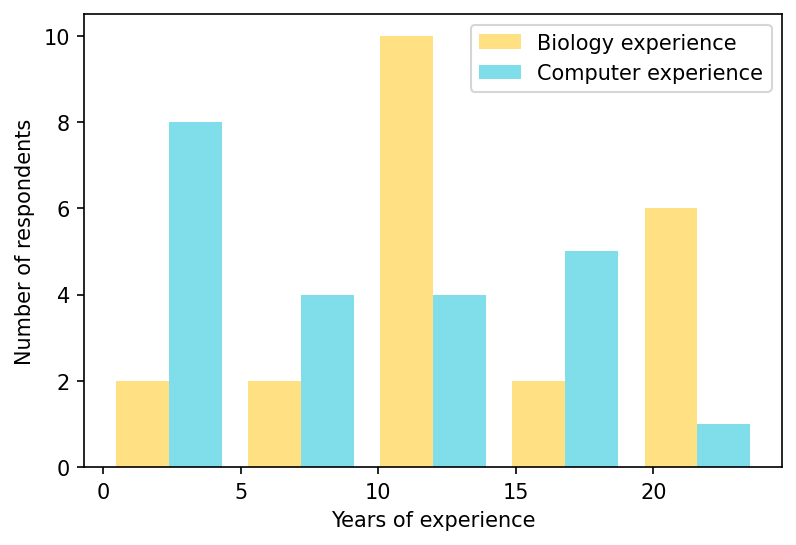

In [51]:
#Exploring the data - what does people's experience look like in a histogram? 

xp_hist = [expanded_backgrounds["years_experience_bio"], expanded_backgrounds["years_experience_computer"]]

plt.hist(xp_hist, bins=5,histtype="bar",color=['#FFE082','#80DEEA'])
plt.xlabel("Years of experience")
plt.ylabel("Number of respondents")
plt.legend(["Biology experience", "Computer experience"])
plt.savefig('figures/bio_computer_xp_years_bar.png',dpi=300)

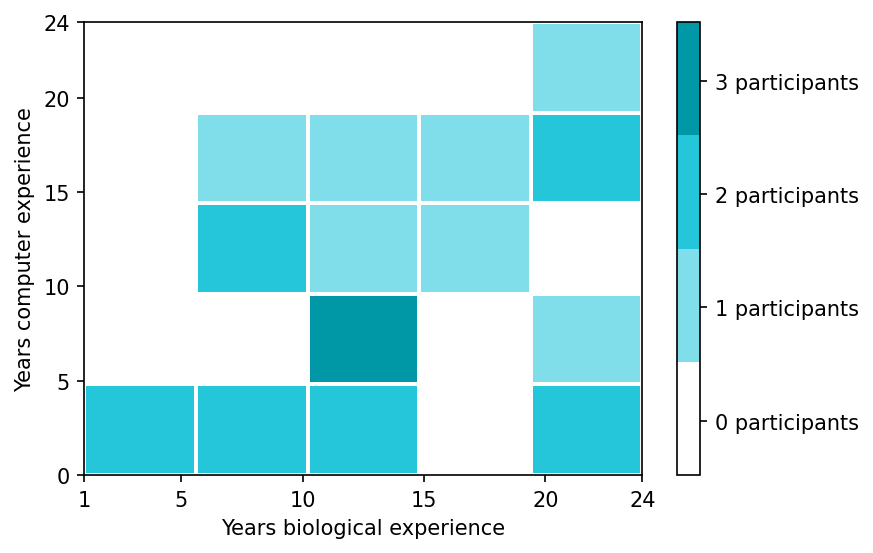

In [87]:
#Heatmap might be more useful than the above diagram
#This is the Figure 1 shown in the paper

color_scale = ['#FFFFFF', '#80DEEA','#26C6DA', '#0097A7']
#color_scale = ['#FFA000','#FFCA28','#FFE082','#0097A7','#26C6DA','#80DEEA']
my_colors_4 = colors.ListedColormap(color_scale)

fig = plt.hist2d(expanded_backgrounds["years_experience_bio"], 
                 expanded_backgrounds["years_experience_computer"], 
                 bins=5, 
                 range=None, density=False, 
                 cmap=my_colors_4,
                 color='w')

my_ticks = [0,1,2,3]
norm = colors.BoundaryNorm(my_ticks, 4)

def tick_to_show(x, pos):
    if(pos in my_ticks):
        return str(pos) + " participants"

fmt = ticker.FuncFormatter(tick_to_show)

colorbar = plt.colorbar(None, ticks=[-0.4,0.85,2.1,3.35], format=fmt, norm=norm)

plt.clim(-1,4)

plt.xlabel('Years biological experience')
plt.ylabel('Years computer experience')

plt.xticks([1, 5, 10, 15, 20, 24])
plt.yticks([0, 5, 10, 15, 20, 24])

plt.savefig('figures/figure1.png',dpi=300)

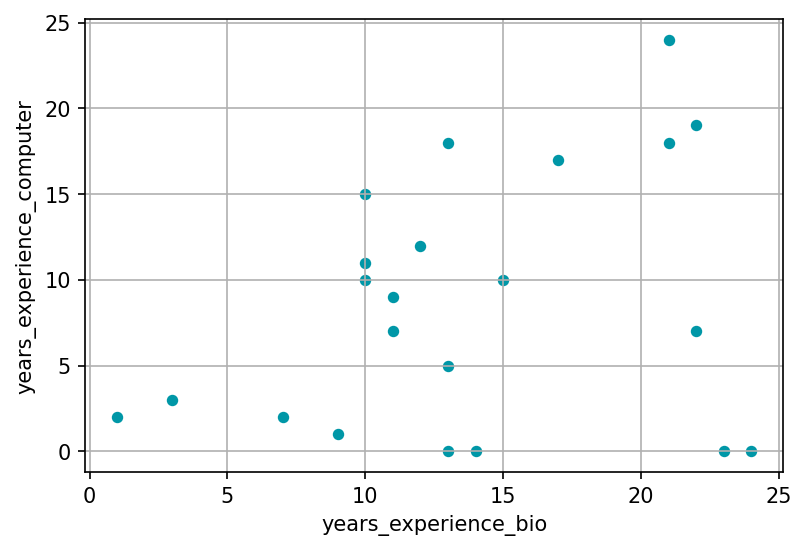

In [45]:
#bio xp (years) vs computer xp (years)
scatterplt = expanded_backgrounds.drop(["Respondent ID"], axis=1)
scatterplt = scatterplt.plot.scatter(x="years_experience_bio", 
                        y="years_experience_computer", 
                        color='#0097A7')
scatterplt.grid(True)
scatterplt.figure.savefig('figures/bio_comp_xp_years_scatterplot.png')

### Formal education levels

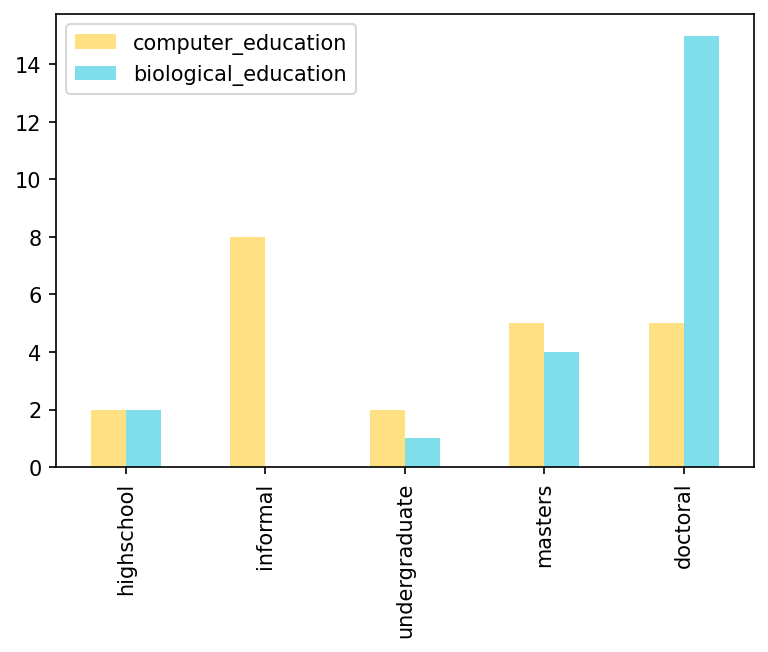

In [52]:
# bio xp (formal education) vs computer xp (formal education)

# First, set up the data categories
degree_order = ["highschool", "informal", "undergraduate", "masters", "doctoral"]

# add category datatypes and make sure it's ordinal
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].astype("category")
expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].astype("category")

expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].cat.set_categories(degree_order, ordered=True)
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].cat.set_categories(degree_order, ordered=True)

#we want to just get the counts of who has which level. 
computer_formal = expanded_backgrounds["computer_education"].value_counts()
bio_formal = expanded_backgrounds["biological_education"].value_counts()

# in order to plot this as a bar chart, we want a df 
# with the categories as the labels and the values as rows
both_formal = pd.DataFrame([computer_formal, bio_formal])

# order based on the degree classification
both_formal = both_formal.T.sort_index()

#visualise
barchart = both_formal.plot.bar(color=['#FFE082','#80DEEA'])
barchart.figure.savefig('figures/bio_computer_formal_bar.png',dpi=300)

In [29]:
# convert the formal education levels to a number in order to fake a plot...
# there might be a better way to do this? 
levels = {
    "highschool" : 1, 
    "informal" : 2, 
    "undergraduate" : 3, 
    "masters": 4, 
    "doctoral": 5
}


bio_numberwise = expanded_backgrounds["biological_education"]
computer_numberwise = expanded_backgrounds["computer_education"]

bio_numberwise = bio_numberwise.map(levels)
computer_numberwise = computer_numberwise.map(levels)


# Background - bio vs computing

In [30]:
formal_scatter_data = pd.DataFrame(data=[bio_numberwise,computer_numberwise])
formal_scatter_data = formal_scatter_data.transpose()

## Years of experience

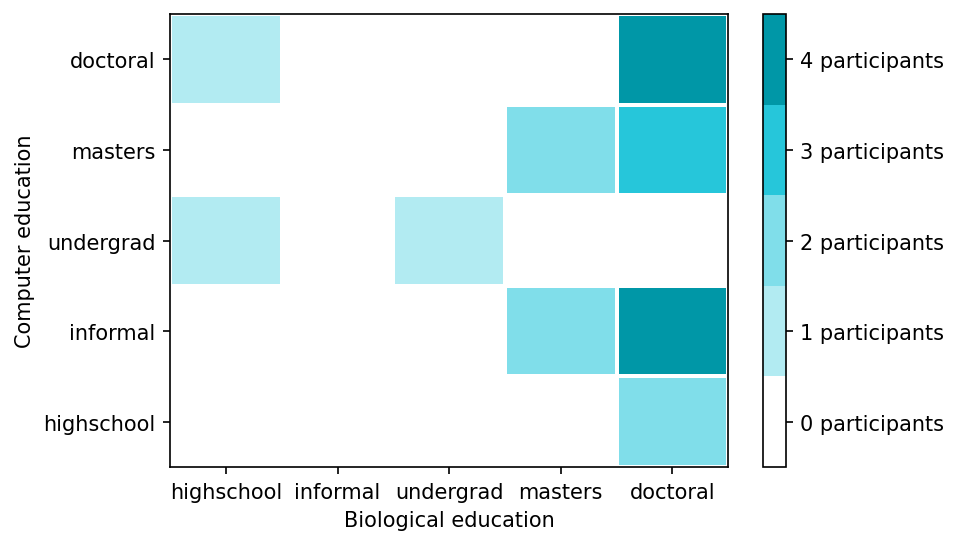

In [93]:
#visualise a heatmap of formal experience bio vs computational

xp_scatter_data = pd.DataFrame(data=[bio_numberwise,computer_numberwise])
xpx1_scatter_data = formal_scatter_data.transpose()

degreescale = ("highschool",
    "informal", 
    "undergrad", 
    "masters",
    "doctoral")

color_scale = ['#FFFFFF','#B2EBF2', '#80DEEA','#26C6DA', '#0097A7']

#color_scale = ['#FFA000','#FFCA28','#FFE082','#0097A7','#26C6DA','#80DEEA']
my_colors_5 = colors.ListedColormap(color_scale)

plt.hist2d(formal_scatter_data["biological_education"], 
           formal_scatter_data["computer_education"], 
           bins=5, 
           color=['w'],
           cmap=my_colors_5)
plt.xlabel('Biological education')
plt.ylabel('Computer education')

## This is a very hacky way to get the labels perfect 😬
plt.xticks([1.4,2.2,3,3.8,4.6], degreescale)
plt.yticks([1.4,2.2,3,3.8,4.6], degreescale)
my_ticks = (0,1,2,3,4)
tick_positions = [-0.4,0.8,2,3.2,4.4]
norm = colors.BoundaryNorm(my_ticks, 5)

def tick_to_show_5(x, pos):
    if(pos in my_ticks):
        return str(pos) + " participants"
fmt = ticker.FuncFormatter(tick_to_show_5)
plt.clim(-1,5)

plt.colorbar(None, 
             ticks=tick_positions, 
             format=fmt, 
             norm=norm)
plt.savefig('figures/bio_computer_formal.png',dpi=300)

In [986]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()),dtype="object")
    print(data)
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)


        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


In [974]:
## This is a utility function to prepare graphs for the personal 
## profile popular programs, languages, and data types


## make a bar chart of most popular programs, files. 
def graph_bg(title, data, file_name): 
    
    # setup ordinal categories for frequency of use
    # First, set up the data categories
    # set up a colour scale for the frequency of use categories above, 
    # where every_(day|week|month) values are set to blue and 
    # infrequent values (yearly or less) are set to yellow
    color_scale = ['#0097A7','#26C6DA','#80DEEA','#FFE082','#FFCA28','#FFA000']

    bg_counts = {}
    
    labels = list()

    #format each column for the barchart

    for label, content in data.items():
        bg_counts[label] = content.value_counts()
        labels.append(label)
        
    # fill empty values 
    

    # in order to plot this as a bar chart, we want a df 
    # with the categories as the labels and the values as rows
    data = pd.DataFrame(bg_counts.values())
    data = data.fillna(0)

    cumulative = data.cumsum(axis=1)    
    data.transpose()
    category_colors = color_scale 

    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)

#     ax.set_xlim(0, 22)


    for i, colname in enumerate(labels):

        widths = data.loc[colname].transpose()
        starts = cumulative.loc[colname].transpose()- widths
#         print("[[[[[")
        print(labels)
        print(starts.values)
#         print(starts)
#         print("]]]]]")
        
        rects = ax.barh(y=labels, width=widths.values, left=starts.values, height=0.5,
                        label=label)
       
        ax.bar_label(rects, label_type='center')
        ax.legend(ncols=len(frequency_of_use_order),
              loc='lower left', fontsize='small')

[[5 1 1 6 5 4]
 [0.0 1.0 0.0 2.0 16.0 3.0]
 [0.0 0.0 0.0 6.0 9.0 7.0]
 [1 1 1 6 4 9]
 [0.0 0.0 0.0 3.0 18.0 1.0]
 [0.0 0.0 0.0 3.0 18.0 1.0]
 [1 1 1 4 8 7]
 [1 5 5 5 2 4]
 [4 7 2 1 1 7]
 [6.0 7.0 7.0 0.0 1.0 1.0]
 [1 3 1 4 4 9]
 [0.0 1.0 0.0 7.0 10.0 4.0]
 [0.0 3.0 2.0 6.0 4.0 7.0]
 [0.0 1.0 1.0 5.0 5.0 10.0]
 [0.0 2.0 1.0 7.0 5.0 7.0]]


(<Figure size 1380x750 with 1 Axes>, <Axes: >)

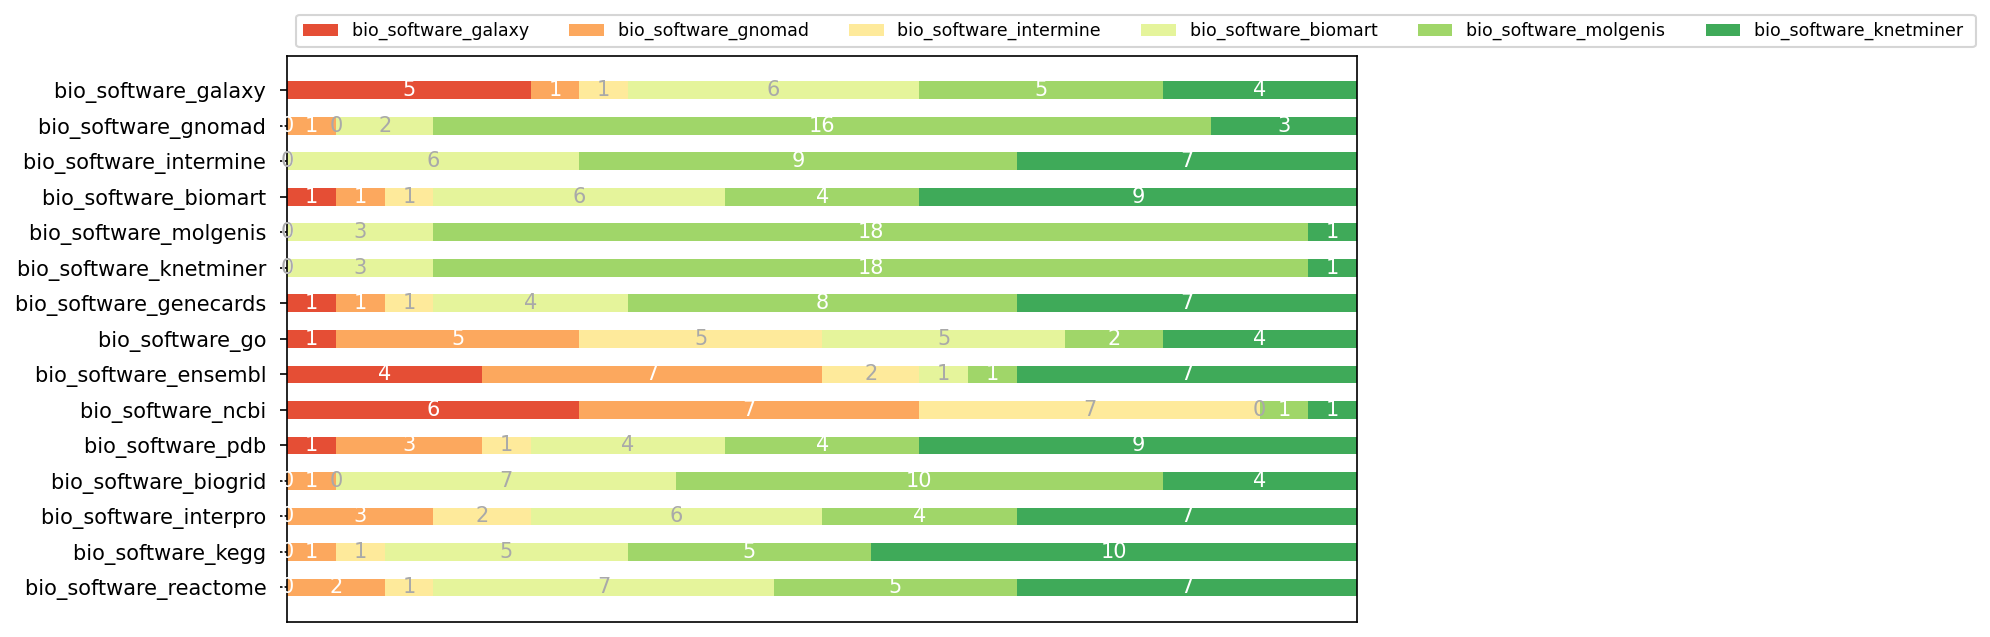

In [1006]:
data=bio_software
bg_counts = {}
labels = list()



#format each column for the barchart
for label, content in data.items():
    vals = content.value_counts()
    labels.append(label)
    bg_counts[label] = vals
    
bg_counts = pd.DataFrame(bg_counts)

bg_counts = bg_counts.fillna(0)

bg_counts = bg_counts.to_dict("list")

frequency_of_use_order = pd.DataFrame(["every_day", " every_week", " every_month"," year_or_less", " heard_of"," never_heard"])
survey(bg_counts, labels)

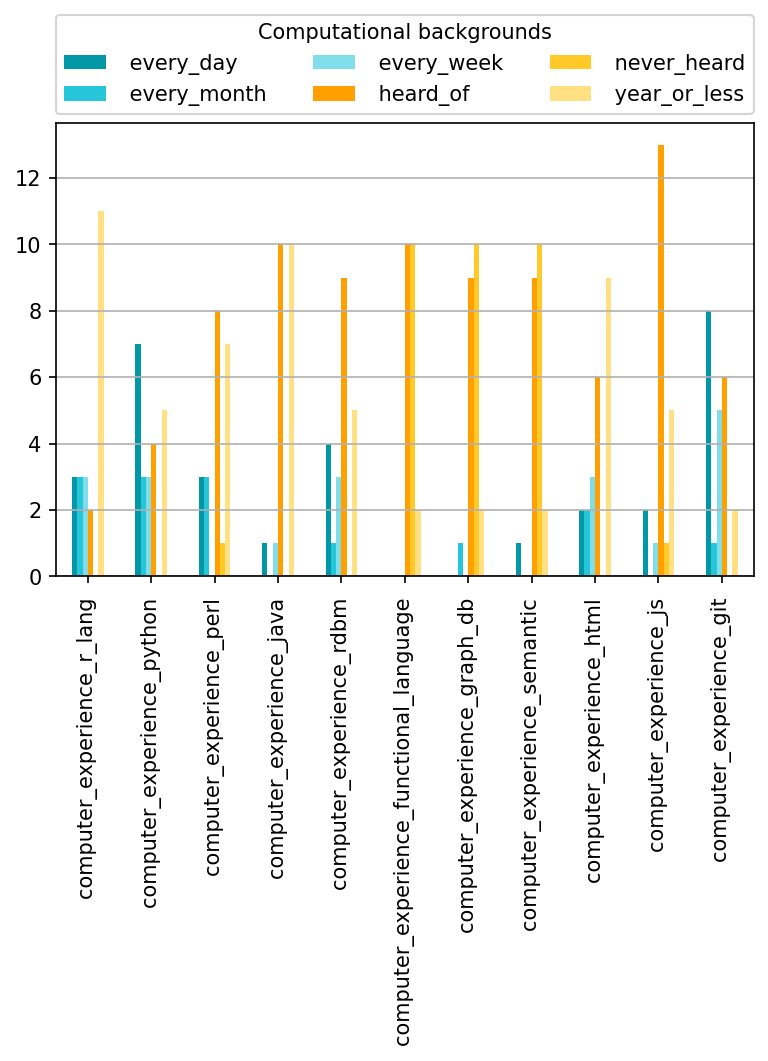

In [34]:
graph_bg("Computational backgrounds", computer_experience, "comp_xp_bg")

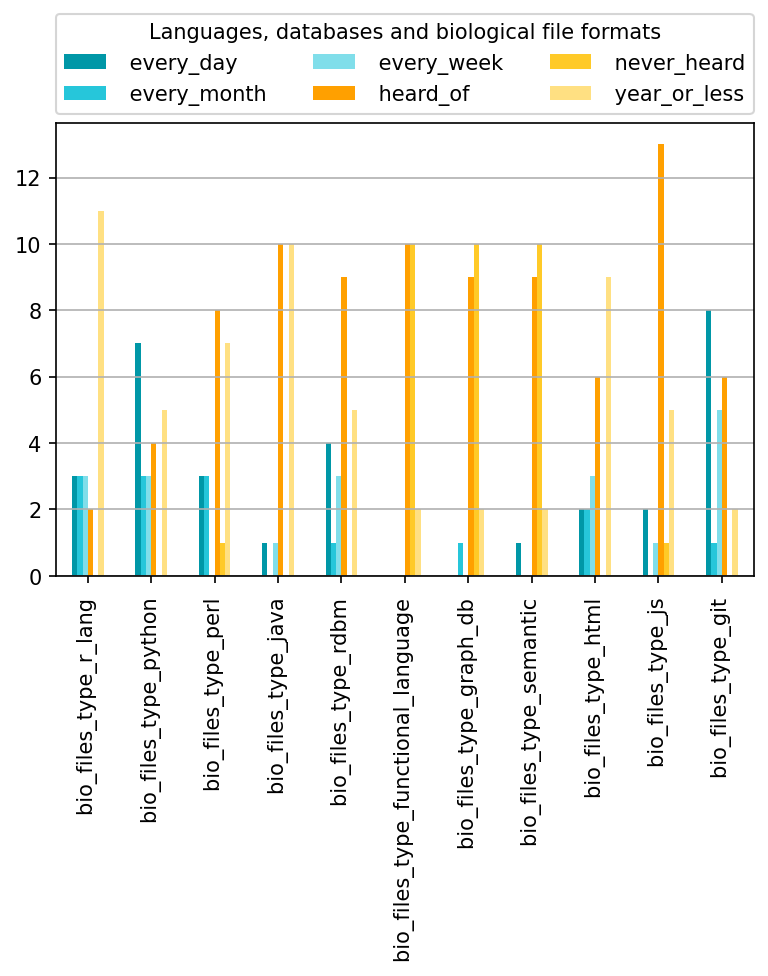

In [35]:
graph_bg("Languages, databases and biological file formats", bio_tech_types, "bio_tech_types_bg")

In [36]:
# add participant identifiers to file
# not sure if we need file names or participant identifiers, let's just build both and see what nvivo likes

# variable to store the final response in as we build it
file_name = list()
participant_id = list()
prefix = ""

id_col = expanded_backgrounds["Respondent ID"]

for i in id_col:
    print(i, id_col[i-1])
    val = id_col[i-1]
    if (val < 10):
        prefix = "0"
    else:
        prefix = ""
    val = str(val)
        
    file_name.append("Files\\\\" + prefix + val + "_transcription")
    participant_id.append("Participant " + val)


participant_id = pd.DataFrame(participant_id)

participant_labelled_data = participant_id.join(expanded_backgrounds)

participant_labelled_data.to_csv("data/expanded_bg.csv",index=False)


1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
